In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data
import config
import network

In [2]:
scan_100307 = process_data.get_nifti_data(config.data_folder2 + '/100307/data.nii.gz')
mask_100307 = process_data.get_nifti_data(config.data_folder2 + '/100307/nodif_brain_mask.nii.gz')
mask_100307_long_pro = process_data.get_mask_pro(scan_100307, mask_100307)

In [3]:
normalized_scan_100307_full = np.load(config.norm_data_path + '/normalized_scan_100307_full.npy')

In [4]:
bvals_all_100307 = np.loadtxt(config.data_folder2 + '/100307/bvals')

In [30]:
selected_indice = [  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187,
       188, 189, 190, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
       218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
       231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243,
       244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256,
       257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269,
       270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282,
       283, 284, 285, 286, 287]

In [31]:
bvals_100307_selected = bvals_all_100307[selected_indice]*1e-3

In [32]:
normalized_scan_100307_sub = normalized_scan_100307_full[:,selected_indice]

In [33]:
big_b_bvals_100307_selected = np.where(bvals_100307_selected != 0.005)[0]

In [34]:
normalized_scan_100307_sub_no_b5 = normalized_scan_100307_sub[:, big_b_bvals_100307_selected]
bvals_100307_selected_no_5 = bvals_100307_selected[big_b_bvals_100307_selected]

In [35]:
n_all_100307 = np.loadtxt(config.data_folder2 + '/100307/bvecs')
n_100307_sub = n_all_100307[:,selected_indice]
n_100307_sub_no_b5 = n_100307_sub[:,big_b_bvals_100307_selected].T
print(n_100307_sub_no_b5.shape)

b_values_100307_sub = torch.FloatTensor(bvals_100307_selected_no_5)
gradient_directions_100307_sub = torch.FloatTensor(n_100307_sub_no_b5)

(224, 3)


In [36]:
net = network.BallStickNet(gradient_directions_100307_sub, b_values_100307_sub)
net.load_state_dict(torch.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-BAS-subsets/Models/model_100206_15g_05.pt"))
net.eval()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=224, out_features=224, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=224, out_features=224, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=224, out_features=224, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=224, out_features=224, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=224, out_features=224, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=224, out_features=224, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=224, out_features=5, bias=True)
  )
)

In [37]:
X_100307_pred, theta_100307_pred, phi_100307_pred, mu_cart_100307_pred, lambda_par_100307_pred, lambda_iso_100307_pred,  volume_0_100307_pred, volume_1_100307_pred = net(torch.from_numpy(normalized_scan_100307_sub_no_b5.astype(np.float32)))

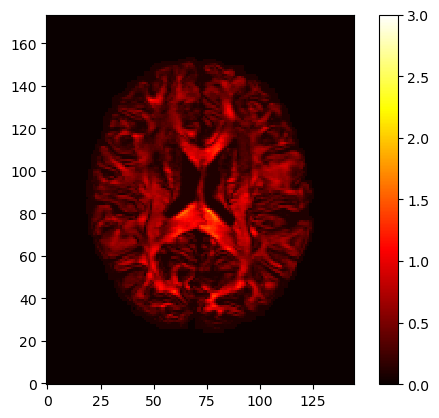

In [38]:
lambda_par_100307_pred_3d = process_data.back_to_3D(mask_100307_long_pro, lambda_par_100307_pred, (145, 174, 145))
im = plt.imshow(lambda_par_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"], vmin = 0, vmax = 3)
plt.colorbar(im)

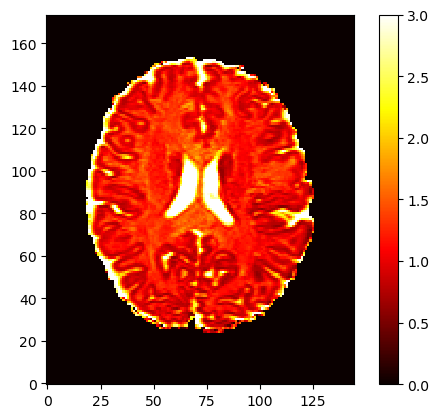

In [39]:
lambda_iso_100307_pred_3d = process_data.back_to_3D(mask_100307_long_pro, lambda_iso_100307_pred, (145, 174, 145))
im = plt.imshow(lambda_iso_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"], vmin = 0, vmax = 3)
plt.colorbar(im)

Golden standard

In [15]:
big_b_indices_100307 = np.where(bvals_all_100307 != 5.)[0]

In [16]:
bvals_100307_no_b5 = bvals_all_100307[big_b_indices_100307]*1e-3

In [17]:
normalized_scan_100307_no_b5 = normalized_scan_100307_full[:, big_b_indices_100307]

In [18]:
n_100307_no_b5 = n_all_100307[:,big_b_indices_100307].T

In [19]:
b_values_100307 = torch.FloatTensor(bvals_100307_no_b5)
gradient_directions_100307 = torch.FloatTensor(n_100307_no_b5)

In [20]:
net_golden_std = network.BallStickNet(gradient_directions_100307, b_values_100307)
net_golden_std.load_state_dict(torch.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-ball-stick/model_100206_norm_01_Feb_182e.pt"))
net_golden_std.eval()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=270, out_features=270, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=270, out_features=270, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=270, out_features=270, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=270, out_features=270, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=270, out_features=270, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=270, out_features=270, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=270, out_features=5, bias=True)
  )
)

In [21]:
X_100307_pred_gstd,theta_100307_pred_gstd, phi_100307_pred_gstd, mu_cart_100307_pred_gstd, lambda_par_100307_pred_gstd, lambda_iso_100307_pred_gstd, volume_0_100307_pred_gstd, volume_1_100307_pred_gstd = net_golden_std(torch.from_numpy(normalized_scan_100307_no_b5.astype(np.float32)))

In [23]:
mu_cart_100307_pred_gstd

tensor([[ 0.1888,  0.5349,  0.6016,  ...,  0.5509, -0.5324, -0.4095],
        [ 0.9579,  0.4682,  0.4306,  ...,  0.8208,  0.6866,  0.8606],
        [ 0.2162, -0.7034, -0.6728,  ...,  0.1508, -0.4952, -0.3029]],
       grad_fn=<CopySlices>)

In [24]:
mu_cart_100307_pred

tensor([[ 0.2312,  0.5892,  0.6408,  ...,  0.6622, -0.4965, -0.2689],
        [ 0.9655,  0.5044,  0.3519,  ...,  0.7448,  0.7196,  0.8891],
        [ 0.1197, -0.6312, -0.6822,  ...,  0.0828, -0.4854, -0.3703]],
       grad_fn=<CopySlices>)

In [ ]:
mse (golden_std(a,b,c) - (a',b',c')

Mean square error

In [22]:
mse = torch.nn.MSELoss(reduction='mean')

cosine similarity

In [23]:
mu_cart_100307_pred_gstd

tensor([[ 0.1888,  0.5349,  0.6016,  ...,  0.5509, -0.5324, -0.4095],
        [ 0.9579,  0.4682,  0.4306,  ...,  0.8208,  0.6866,  0.8606],
        [ 0.2162, -0.7034, -0.6728,  ...,  0.1508, -0.4952, -0.3029]],
       grad_fn=<CopySlices>)

In [25]:
mu_cart_100307_pred

tensor([[-0.2386,  0.2048,  0.1617,  ...,  0.3325, -0.2660, -0.0785],
        [ 0.9321,  0.8123,  0.8101,  ...,  0.9092,  0.9400,  0.9806],
        [-0.2724, -0.5461, -0.5635,  ..., -0.2508, -0.2136,  0.1797]],
       grad_fn=<CopySlices>)

In [24]:
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)
output = cos(mu_cart_100307_pred_gstd, mu_cart_100307_pred)
print(output)

tensor([0.8810, 0.9979, 0.9855,  ..., 0.9401, 0.9713, 0.9968],
       grad_fn=<SumBackward1>)


In [35]:
output.shape

torch.Size([740145])

In [36]:
print(torch.min(output))

tensor(-1.0000, grad_fn=<MinBackward1>)


In [37]:
print(torch.max(output))

tensor(1., grad_fn=<MaxBackward1>)


(array([1.27600e+03, 6.76000e+02, 7.60000e+02, 8.95000e+02, 1.14200e+03,
        1.61800e+03, 2.68000e+03, 5.10500e+03, 1.52900e+04, 7.10703e+05]),
 array([-9.99974072e-01, -7.99976647e-01, -5.99979222e-01, -3.99981827e-01,
        -1.99984401e-01,  1.30236149e-05,  2.00010449e-01,  4.00007874e-01,
         6.00005269e-01,  8.00002694e-01,  1.00000012e+00]),
 <BarContainer object of 10 artists>)

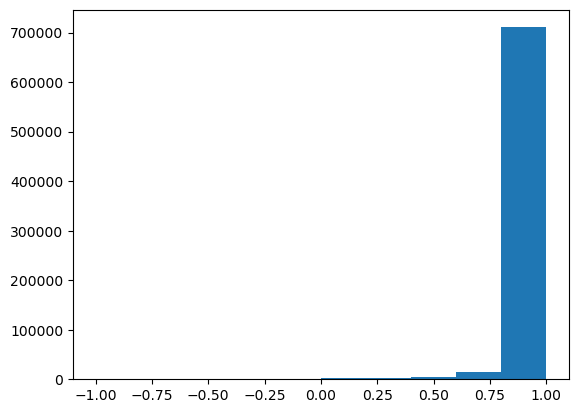

In [25]:
plt.hist(output.detach().numpy())

In [293]:
n_100307_sub_no_b5

array([[ 0.940461, -0.284911, -0.185364],
       [ 0.33274 ,  0.874787,  0.352182],
       [ 0.062696, -0.395116,  0.916489],
       [ 0.195299,  0.895544, -0.399822],
       [ 0.469331, -0.795541, -0.383201],
       [ 0.702082, -0.474367,  0.531089],
       [ 0.277576,  0.337181,  0.899589],
       [-0.636052, -0.084263,  0.767032],
       [ 0.882737,  0.450147,  0.134699],
       [ 0.224295, -0.886244, -0.405294],
       [ 0.201882,  0.12566 ,  0.971315],
       [ 0.843525, -0.420447,  0.334199],
       [-0.448841, -0.255421,  0.85633 ],
       [ 0.972035,  0.234314, -0.015665],
       [ 0.273082,  0.950462, -0.148486],
       [-0.248187, -0.817088, -0.520356],
       [-0.610885,  0.783998, -0.110305],
       [ 0.610531,  0.764556, -0.206656],
       [-0.176929,  0.260081, -0.949238],
       [ 0.202136, -0.498691,  0.84288 ],
       [-0.873268,  0.362527,  0.325542],
       [ 0.883453, -0.188046,  0.429126],
       [-0.337405,  0.043314,  0.940362],
       [-0.047389,  0.99335 , -0.1

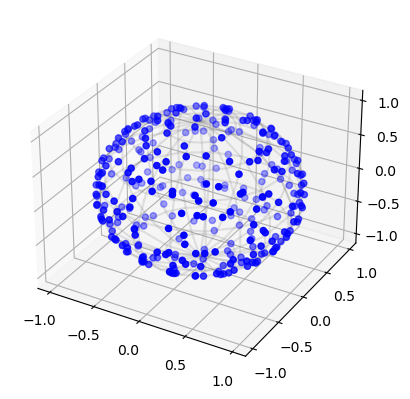

In [42]:

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the normalized gradient directions
ax.scatter(n_100307_sub_no_b5[:, 0], n_100307_sub_no_b5[:, 1], n_100307_sub_no_b5[:, 2], c='b', marker='o')
ax.scatter(-n_100307_sub_no_b5[:, 0], -n_100307_sub_no_b5[:, 1], -n_100307_sub_no_b5[:, 2], c='b', marker='o')

# # Set limits of the plot to fit the sphere
# ax.set_xlim([-1, 1])
# ax.set_ylim([-1, 1])
# ax.set_zlim([-1, 1])

# # Set equal aspect ratio for all three axes
# ax.set_box_aspect([1, 1, 1])

# Add a sphere to the plot
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
ax.plot_wireframe(x, y, z, color='gray', alpha=0.2)

# # Show the plot
# plt.show()
# plot 
# Check the 

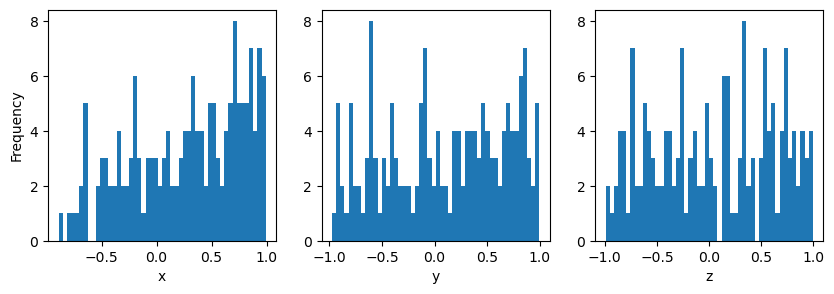

In [41]:
# Create histograms of the gradient directions along each axis
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].hist(n_100307_sub_no_b5[:, 0], bins=50)
axs[0].set_xlabel('x')
axs[0].set_ylabel('Frequency')
axs[1].hist(n_100307_sub_no_b5[:, 1], bins=50)
axs[1].set_xlabel('y')
axs[2].hist(n_100307_sub_no_b5[:, 2], bins=50)
axs[2].set_xlabel('z')
plt.show()

When using half measurements

Apply model_100206_11_01.pt

In [85]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0017, grad_fn=<MseLossBackward0>)
tensor(0.0058, grad_fn=<MseLossBackward0>)
tensor(0.0001, grad_fn=<MseLossBackward0>)
tensor(0.0001, grad_fn=<MseLossBackward0>)


Apply model_100206_11_02.pt

In [106]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0045, grad_fn=<MseLossBackward0>)
tensor(0.0056, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)


Apply model_100206_11_03.pt

In [236]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0061, grad_fn=<MseLossBackward0>)
tensor(0.0060, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)


In [40]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0157, grad_fn=<MseLossBackward0>)
tensor(0.0070, grad_fn=<MseLossBackward0>)
tensor(0.0005, grad_fn=<MseLossBackward0>)
tensor(0.0005, grad_fn=<MseLossBackward0>)


In [264]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0039, grad_fn=<MseLossBackward0>)
tensor(0.0080, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)


Apply model_100206_13_01.pt

In [56]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0147, grad_fn=<MseLossBackward0>)
tensor(0.0370, grad_fn=<MseLossBackward0>)
tensor(0.0026, grad_fn=<MseLossBackward0>)
tensor(0.0026, grad_fn=<MseLossBackward0>)


Apply model_100206_13_02.pt

In [71]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0046, grad_fn=<MseLossBackward0>)
tensor(0.0312, grad_fn=<MseLossBackward0>)
tensor(0.0023, grad_fn=<MseLossBackward0>)
tensor(0.0023, grad_fn=<MseLossBackward0>)


Apply model_100206_13_03.pt

In [179]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0038, grad_fn=<MseLossBackward0>)
tensor(0.0046, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)


Apply model_100206_13_04.pt

In [197]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0038, grad_fn=<MseLossBackward0>)
tensor(0.0051, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)


Apply model_100206_13_05.pt

In [208]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0044, grad_fn=<MseLossBackward0>)
tensor(0.0039, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)


Apply model_100206_13_06.pt

In [222]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0020, grad_fn=<MseLossBackward0>)
tensor(0.0040, grad_fn=<MseLossBackward0>)
tensor(0.0001, grad_fn=<MseLossBackward0>)
tensor(0.0001, grad_fn=<MseLossBackward0>)


Apply model_100206_15_01.pt

In [43]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0032, grad_fn=<MseLossBackward0>)
tensor(0.0029, grad_fn=<MseLossBackward0>)
tensor(0.0001, grad_fn=<MseLossBackward0>)
tensor(0.0001, grad_fn=<MseLossBackward0>)


Apply model_100206_15_02.pt

In [29]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0033, grad_fn=<MseLossBackward0>)
tensor(0.0057, grad_fn=<MseLossBackward0>)
tensor(0.0001, grad_fn=<MseLossBackward0>)
tensor(0.0001, grad_fn=<MseLossBackward0>)


Apply model_100206_15_04.pt

In [26]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0018, grad_fn=<MseLossBackward0>)
tensor(0.0032, grad_fn=<MseLossBackward0>)
tensor(9.1013e-05, grad_fn=<MseLossBackward0>)
tensor(9.1013e-05, grad_fn=<MseLossBackward0>)


Apply model_100206_15_05.pt

In [40]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0027, grad_fn=<MseLossBackward0>)
tensor(0.0029, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)


Apply model_100206_half_01.pt

In [26]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0033, grad_fn=<MseLossBackward0>)
tensor(0.0057, grad_fn=<MseLossBackward0>)
tensor(0.0001, grad_fn=<MseLossBackward0>)
tensor(0.0001, grad_fn=<MseLossBackward0>)


Apply model_100206_half_02.pt

In [45]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)

In [46]:
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0046, grad_fn=<MseLossBackward0>)
tensor(0.0088, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)


Apply model_100206_half_03.pt

In [128]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0034, grad_fn=<MseLossBackward0>)
tensor(0.0080, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)


Apply model_100206_half_04.pt

In [167]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0027, grad_fn=<MseLossBackward0>)
tensor(0.0069, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)


Apply model_100206_half_05.pt

In [179]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0092, grad_fn=<MseLossBackward0>)
tensor(0.0077, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)


Apply model_100206_half_06.pt

In [195]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0086, grad_fn=<MseLossBackward0>)
tensor(0.0081, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)


When using 8 groups of measurements

Apply model_100206_8g_01.pt

In [86]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0059, grad_fn=<MseLossBackward0>)
tensor(0.0348, grad_fn=<MseLossBackward0>)
tensor(0.0024, grad_fn=<MseLossBackward0>)
tensor(0.0024, grad_fn=<MseLossBackward0>)


Apply model_100206_8g_02.pt

In [74]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)

In [75]:
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0043, grad_fn=<MseLossBackward0>)
tensor(0.0108, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)


Apply model_100206_8g_03.pt

In [23]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0058, grad_fn=<MseLossBackward0>)
tensor(0.0098, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)


When using 7 groups of measurements

Apply model_100206_7g_02.pt

In [283]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0051, grad_fn=<MseLossBackward0>)
tensor(0.0118, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)


Apply model_100206_7g_03.pt

In [60]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)

In [61]:
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0094, grad_fn=<MseLossBackward0>)
tensor(0.0110, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)


Apply model_100206_7g_04.pt

In [37]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0064, grad_fn=<MseLossBackward0>)
tensor(0.0266, grad_fn=<MseLossBackward0>)
tensor(0.0018, grad_fn=<MseLossBackward0>)
tensor(0.0018, grad_fn=<MseLossBackward0>)


In [42]:
distance = get_mean_euclidean_distance(mu_cart_100307_pred_gstd, mu_cart_100307_pred)

In [43]:
distance

tensor(1.8668, grad_fn=<MeanBackward0>)

In [34]:
mu_cart_100307_pred_gstd

tensor([[ 0.1888,  0.5349,  0.6016,  ...,  0.5509, -0.5324, -0.4095],
        [ 0.9579,  0.4682,  0.4306,  ...,  0.8208,  0.6866,  0.8606],
        [ 0.2162, -0.7034, -0.6728,  ...,  0.1508, -0.4952, -0.3029]],
       grad_fn=<CopySlices>)

In [35]:
mu_cart_100307_pred

tensor([[-0.3860, -0.5575, -0.5352,  ..., -0.6136,  0.1787,  0.1740],
        [-0.9059, -0.5200, -0.6355,  ..., -0.7601, -0.6667, -0.7992],
        [-0.1741,  0.6471,  0.5566,  ..., -0.2138,  0.7236,  0.5753]],
       grad_fn=<CopySlices>)

When using 6 groups of measurements

In [102]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0059, grad_fn=<MseLossBackward0>)
tensor(0.0142, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)


Apply model_100206_6g_02.pt

In [121]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0052, grad_fn=<MseLossBackward0>)
tensor(0.0135, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)


When using 5 groups of measurements

Apply model_100206_quarter_01.pt

In [255]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0060, grad_fn=<MseLossBackward0>)
tensor(0.0184, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)


Apply model_100206_5g_02.pt

In [136]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0136, grad_fn=<MseLossBackward0>)
tensor(0.0438, grad_fn=<MseLossBackward0>)
tensor(0.0032, grad_fn=<MseLossBackward0>)
tensor(0.0032, grad_fn=<MseLossBackward0>)


Apply model_100206_5g_03.pt

In [151]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0087, grad_fn=<MseLossBackward0>)
tensor(0.0155, grad_fn=<MseLossBackward0>)
tensor(0.0005, grad_fn=<MseLossBackward0>)
tensor(0.0005, grad_fn=<MseLossBackward0>)


When using 1 groups of measurements

Apply model_100206_single_01.pt

In [269]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0357, grad_fn=<MseLossBackward0>)
tensor(0.0783, grad_fn=<MseLossBackward0>)
tensor(0.0029, grad_fn=<MseLossBackward0>)
tensor(0.0029, grad_fn=<MseLossBackward0>)


In [ ]:
tensor(0.0018, grad_fn=<MseLossBackward0>)
tensor(0.0032, grad_fn=<MseLossBackward0>)
tensor(9.1013e-05, grad_fn=<MseLossBackward0>)
tensor(9.1013e-05, grad_fn=<MseLossBackward0>)

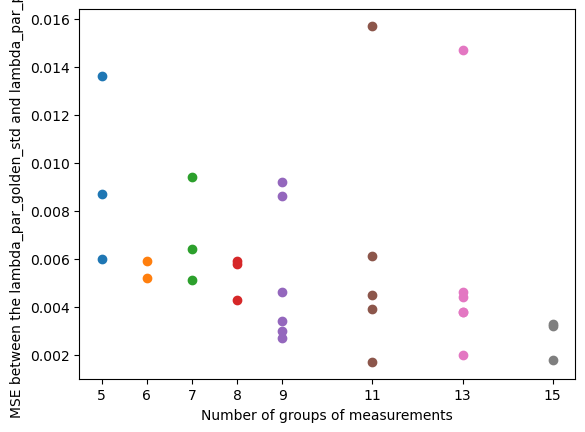

In [27]:
# x_values = [1, 5, 6, 7, 8, 9]
# y_values = [[0.0357], [0.0060], [0.0059], [0.0051, 0.0094], [0.0059, 0.0043], [0.0030, 0.0046, 0.0034, 0.0027, 0.0092, 0.0086]]
x_values = [5, 6, 7, 8, 9, 11, 13, 15]
y_values = [[0.0060, 0.0136,0.0087], [0.0059,0.0052], [0.0051, 0.0094, 0.0064], [0.0059, 0.0043, 0.0058], [0.0030, 0.0046, 0.0034, 0.0027, 0.0092, 0.0086],[0.0017, 0.0045,0.0061,0.0157,0.0039], [0.0147,0.0046,0.0038,0.0038,0.0044,0.0020],[0.0032,0.0033,0.0018]]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of groups of measurements')
ax.set_ylabel('MSE between the lambda_par_golden_std and lambda_par_pred')

ax.set_xticks(x_values)

# best pred using 9 gropus of measurements
# -> b values /  * gradient direction arr in shape of (3, 288)
#                 scoring 统计差不多的方向（a,b,c）的数量，展现方向的distribution (histgram)
    
# mean((pred-mean(ground_truth))^2)
# avg_acc variance 
# simulated signals

# 蒙特卡洛采样


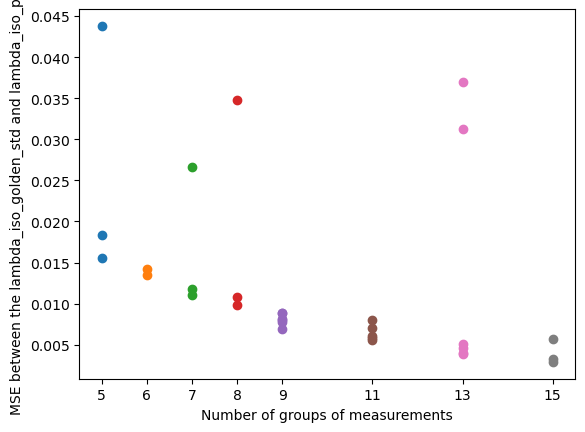

In [28]:
# x_values = [1, 5, 6, 7, 8, 9]
# y_values = [[0.0783], [0.0184], [0.0142], [0.0118, 0.0110], [0.0348, 0.0108], [0.0089, 0.0088, 0.0080, 0.0069, 0.0077, 0.0081]]
x_values = [5, 6, 7, 8, 9,11, 13,15]
y_values = [[0.0184, 0.0438,0.0155], [0.0142,0.0135], [0.0118, 0.0110, 0.0266], [0.0348, 0.0108, 0.0098], [0.0089, 0.0088, 0.0080, 0.0069, 0.0077, 0.0081], [0.0058, 0.0056,0.0060,0.0070,0.0080], [0.0370, 0.0312, 0.0046,0.0051,0.0039,0.0040],[0.0029,0.0057,0.0032]]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of groups of measurements')
ax.set_ylabel('MSE between the lambda_iso_golden_std and lambda_iso_pred')

ax.set_xticks(x_values)

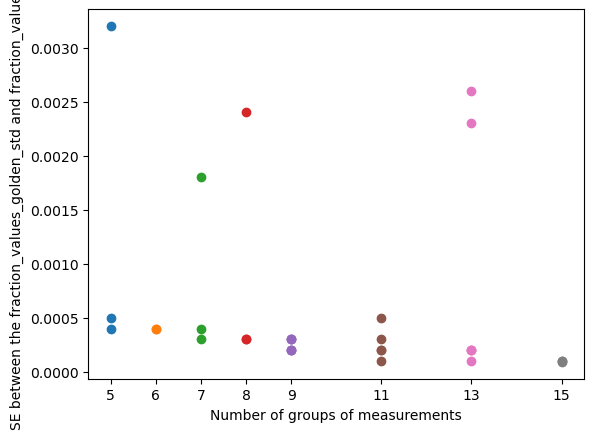

In [29]:
# x_values = [1, 5, 6, 7, 8, 9]
# y_values = [[0.0029], [0.0004], [0.0004], [0.0003, 0.0004], [0.0024, 0.0003], [0.0002, 0.0003, 0.0002, 0.0002, 0.0003, 0.0003]]
x_values = [5, 6, 7, 8, 9, 11, 13, 15]
y_values = [[0.0004,0.0032,0.0005], [0.0004,0.0004], [0.0003, 0.0004, 0.0018], [0.0024, 0.0003, 0.0003], [0.0002, 0.0003, 0.0002, 0.0002, 0.0003, 0.0003],[0.0001, 0.0002,0.0003,0.0005,0.0002], [0.0026, 0.0023, 0.0002,0.0002,0.0002,0.0001],[0.0001,0.0001,9.1013e-05]]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of groups of measurements')
ax.set_ylabel('MSE between the fraction_values_golden_std and fraction_values_pred')

ax.set_xticks(x_values)

In [ ]:
# mean((p - mean(gtd))^2) 

In [112]:
rand_sub_bval_indice_100307 = np.array(process_data.get_rand_selected_bval_indice(bvals_all_100307, 9))

In [111]:
np.unique(bvals_all_100307[rand_sub_bval_indice_100307])

array([   5.,  990.,  995., 1000., 1005., 1985., 1990., 1995., 2000.,
       2005., 2010., 2980., 2985., 2990., 2994., 2995., 3000., 3005.,
       3010.])

In [113]:
np.unique(bvals_all_100307[rand_sub_bval_indice_100307])

array([   5.,  990.,  995., 1000., 1005., 1985., 1990., 1995., 2000.,
       2005., 2010., 2980., 2985., 2990., 2995., 3000., 3005., 3010.])

In [ ]:
# Training data 1000 2000 3000

# Testing data 3000 2000 1000